<a href="https://colab.research.google.com/github/PanthaLasso/Practice-Notebooks/blob/main/k_means_mall_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering - A Beginner's Guide

## Introduction

K-Means clustering is an unsupervised machine learning algorithm that groups data points into clusters based on similarity. The goal of the algorithm is to partition the data into **k** distinct clusters, where each data point belongs to the cluster with the nearest mean (centroid).

In this notebook, we'll perform K-Means clustering on a dataset and visualize the results, step by step.

---


### Importing Required Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Loading the Dataset

The first step in any data analysis task is to load the dataset. In this case, we are using the **Mall_Customers.csv** dataset, which contains customer information for a mall. We will use **Pandas** to load the data into a DataFrame.


In [3]:
df = pd.read_csv("/content/Mall_Customers.csv")
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

## Exploratory Data Analysis
### Understanding the Data Structure
Now that we have loaded the dataset, it‚Äôs important to explore its structure. We will use several functions to get an overview of the dataset, including its shape, column information, and summary statistics.


In [4]:
df.info()
df.shape
# Printing the shape of the dataset
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
The dataset has 200 rows and 5 columns.


- There are no missing values (non-null count is 200 for all columns).
* The data types include 4 columns as integers (int64) and 1 column as an object (the Gender column).-

In [5]:
df.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

#### The df.describe() function provides a statistical summary of the numerical columns. It calculates the count, mean, standard deviation, minimum, and maximum values, as well as the 25th, 50th, and 75th percentiles.
- CustomerID: This is an identifier column with values ranging from 1 to 200.
- Age: The average age of customers is around 38.85, with a standard deviation of 13.97. Ages range from 18 to 70.
- Annual Income (k$): The average annual income is around 60.56k, with a range from 15k to 137k.
- Spending Score (1-100): The average spending score is around 50.2, with scores ranging from 1 to 99.

### DISTRIBUTION OF FEATURES

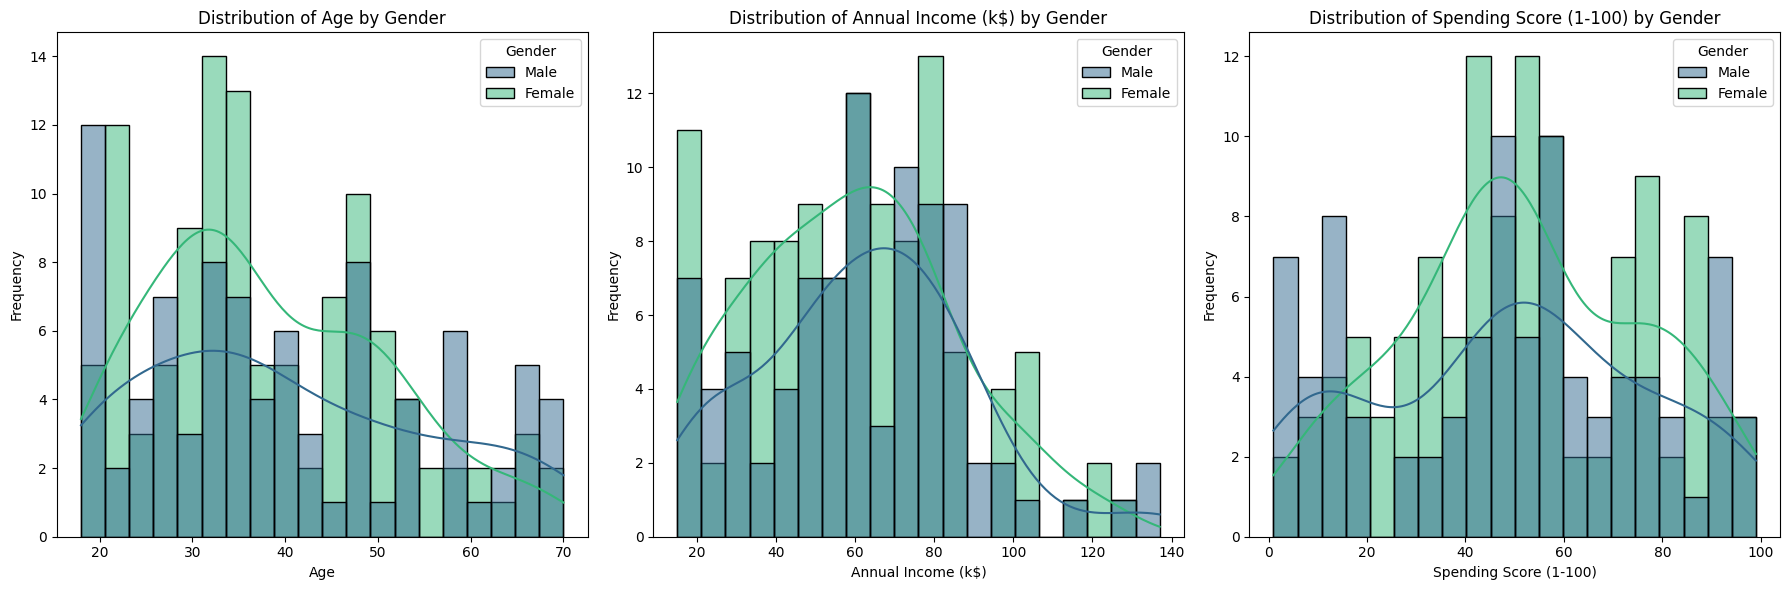

In [6]:
# List of features to plot
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create a 1x3 subplot grid (for 3 features)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the features and create a plot for each
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue='Gender', bins=20, kde=True, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Gender')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig('Distribution_of_Features_by_Gender.png')
plt.show()


## Insights from Gender-Based Distributions

1. **Age Distribution**:
   - More female customers fall in the 30‚Äì40 age range compared to males.
   - Males have a relatively even age distribution, whereas females show a peak in the mid-age range.

2. **Annual Income Distribution**:
   - Both genders follow a similar income distribution, peaking around 60‚Äì80k$.
   - Males exhibit a slightly broader spread of income levels.

3. **Spending Score Distribution**:
   - Females tend to have higher spending scores, particularly in the 40‚Äì60


## PAIR PLOTS BETWEEN FEATURES

<Figure size 1200x1000 with 0 Axes>

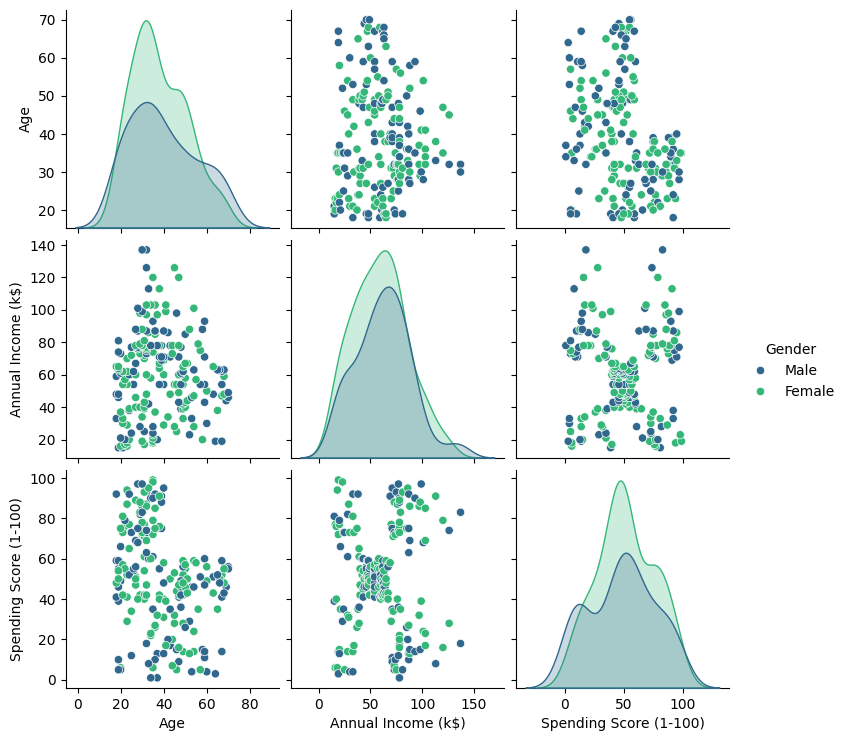

In [7]:
plt.figure(figsize=(12, 10))
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']], hue='Gender', palette='viridis')
plt.savefig('Pair Plot Visualization of features')
plt.show()

## Insights from Pairplot of Customer Attributes by Gender

1. **Age Distribution**:
   - More females are concentrated in the 30‚Äì40 age range, while males have a more even distribution.
   - The density plot shows a higher peak for females in this range.

2. **Annual Income vs. Age**:
   - No strong correlation between age and annual income for either gender.
   - Both genders show a similar spread of income across different ages.

3. **Spending Score vs. Age**:
   - Spending score generally decreases with age for both genders.
   - Younger individuals tend to have higher spending scores.

4. **Annual Income vs. Spending Score**:
   - No clear linear relationship, but certain income groups show higher spending scores.
   - Females exhibit slightly higher spending scores than males for similar income levels.

5. **Gender Differences**:
   - Overall, females have higher spending scores and are more concentrated in specific age ranges.
   - Males have a broader spread across different attributes.


### CORRELATION HEATMAP

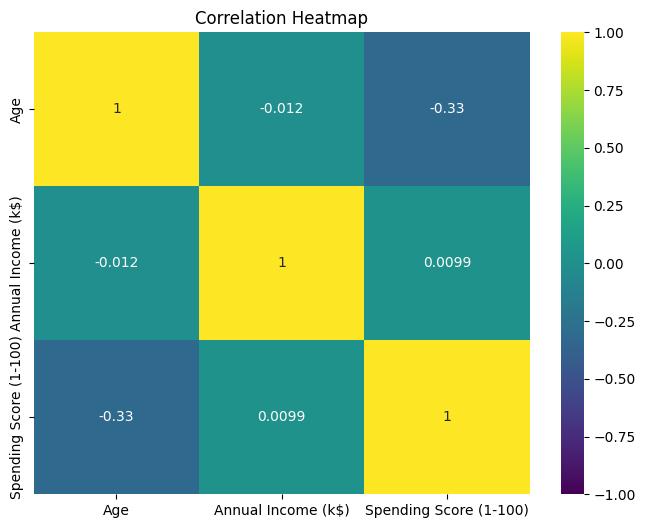

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap')
plt.show()


### Insights from Correlation Heatmap

1. **Age vs. Spending Score**:
   - Moderate negative correlation (-0.33), indicating that older individuals tend to have lower spending scores.

2. **Annual Income vs. Spending Score**:
   - Very weak correlation (0.0099), suggesting that spending behavior is not strongly linked to income levels.

3. **Age vs. Annual Income**:
   - Almost no correlation (-0.012), meaning age does not significantly influence income.

4. **Key Takeaways**:
   - Spending score decreases with age but is independent of income.
   - Age and income are not directly related.
   - No strong correlations exist among the given attributes.


## SPENDING SCORE WITHE AGE AND GENDER

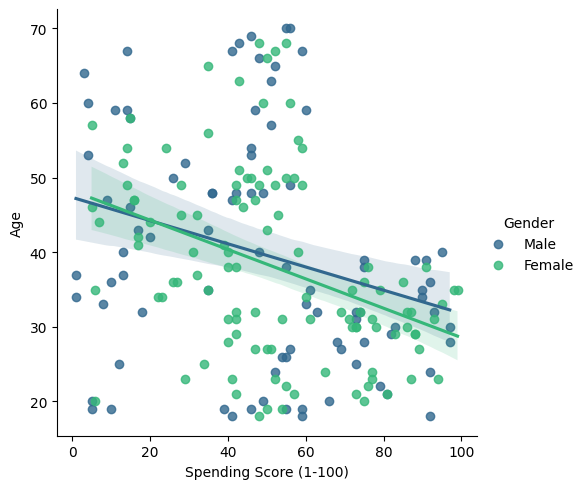

In [9]:
sns.lmplot(df,x = 'Spending Score (1-100)' , y='Age' , hue = 'Gender', palette = 'viridis')
plt.savefig('Spending Score Scatter Plot with Implot bY Gender')

### Insights from the Spending Score vs. Age Scatter Plot

- **Negative Correlation**: As age increases, the spending score tends to decrease.
- **Gender Distribution**: Both male and female customers are spread across the plot, with no significant clustering by gender.
- **Younger Customers Spend More**: Higher spending scores are more frequent among younger individuals.
- **Older Customers Spend Less**: Older individuals tend to have lower spending scores.
- **Trend Line Confirmation**: The regression line with a confidence interval reinforces the negative relationship between age and spending score.


### GENDER VISUALIZATION

In [10]:
# Count the occurrences of each gender
gender_counts = df['Gender'].value_counts()
gender_counts

Gender
Female    112
Male       88
Name: count, dtype: int64

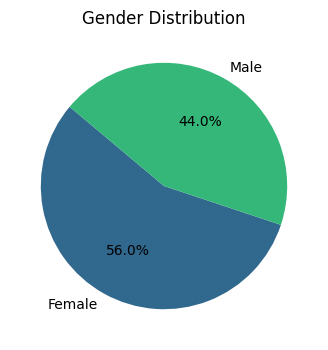

In [11]:
colors = sns.color_palette('viridis', len(gender_counts))

plt.figure(figsize=(4,4 ))
plt.pie(gender_counts, labels=gender_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.savefig('Gender Distribution')
plt.show()

### there are 56% female and 44% male customers in the dataset
--------------


### Data Preprocessing: Transformation of Numerical and Categorical Features

In this step, we transform both numerical and categorical features using different preprocessing techniques.

#### 1. **Numerical Features Transformation**:
   - **Features**: `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`.
   - **Transformation**: These features are scaled using the **StandardScaler**. Scaling standardizes the numerical values to have a mean of 0 and a standard deviation of 1. This is important to bring all numerical features to the same scale, especially when using models sensitive to feature magnitudes.

#### 2. **Categorical Features Transformation**:
   - **Feature**: `Gender`.
   - **Transformation**: The categorical feature `Gender` is transformed using **OrdinalEncoder**, which converts the categorical values into numerical representations (such as 0 and 1 for 'Male' and 'Female'). This allows the model to interpret categorical values numerically.

#### 3. **Combining the Transformers**:
   - A **ColumnTransformer** is used to apply the appropriate transformations to the corresponding features. Numerical features undergo scaling, while categorical features undergo encoding. This ensures that each feature is processed using the correct method.
   
#### 4. **Output**:
   - The transformed features are stored in a new DataFrame `transformed_df`, with updated feature names for the encoded categorical features. The final DataFrame has columns corresponding to the transformed numerical features and the encoded categorical features.


In [12]:
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_features = ['Gender']

# transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # Encode categorical features
])

#  preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [13]:
X_transformed = preprocessor.fit_transform(df)

In [14]:
ordinal_feature_names = [f'{col}_encoded' for col in categorical_features]  # Feature names for encoded categorical features
feature_names = numerical_features + ordinal_feature_names

In [15]:
transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

transformed_df.head()

Age  Annual Income (k$)  Spending Score (1-100)  Gender_encoded
0 -1.424569           -1.738999               -0.434801             1.0
1 -1.281035           -1.738999                1.195704             1.0
2 -1.352802           -1.700830               -1.715913             0.0
3 -1.137502           -1.700830                1.040418             0.0
4 -0.563369           -1.662660               -0.395980             0.0

In [16]:
import os

# Set the environment variable to limit the number of threads
os.environ['OMP_NUM_THREADS'] = '1'
from sklearn.cluster import KMeans

### K-Means Clustering Analysis: Elbow and Silhouette Score Visualization

This section performs **K-Means clustering** on the transformed dataset for different values of **k** (number of clusters) and visualizes the results using two key metrics: **Inertia** and **Silhouette Score**.

#### 1. **Inertia (Elbow Method)**:
   - **Definition**: Inertia measures the sum of squared distances from each point to its assigned cluster center. Lower values indicate better clustering. The **Elbow Method** helps determine the optimal number of clusters by identifying the "elbow point," where inertia starts to decrease at a slower rate.
   - **Process**: We run K-Means clustering for **k = 1 to 10** and record the inertia for each k.

#### 2. **Silhouette Score**:
   - **Definition**: The Silhouette Score measures how similar each point is to its own cluster compared to other clusters. A higher score indicates that the points are well-clustered. This score ranges from -1 (poor clustering) to 1 (good clustering).
   - **Process**: For each k > 1, we calculate the silhouette score based on the cluster labels from the K-Means algorithm.

#### 3. **Visualizing the Results**:
   - **Elbow Curve**: The first plot shows inertia for different values of k. This helps identify the optimal number of clusters by looking for the "elbow" point.
   - **Silhouette Scores**: The second plot shows the silhouette scores for different values of k, helping to evaluate the quality of the clusters.
   

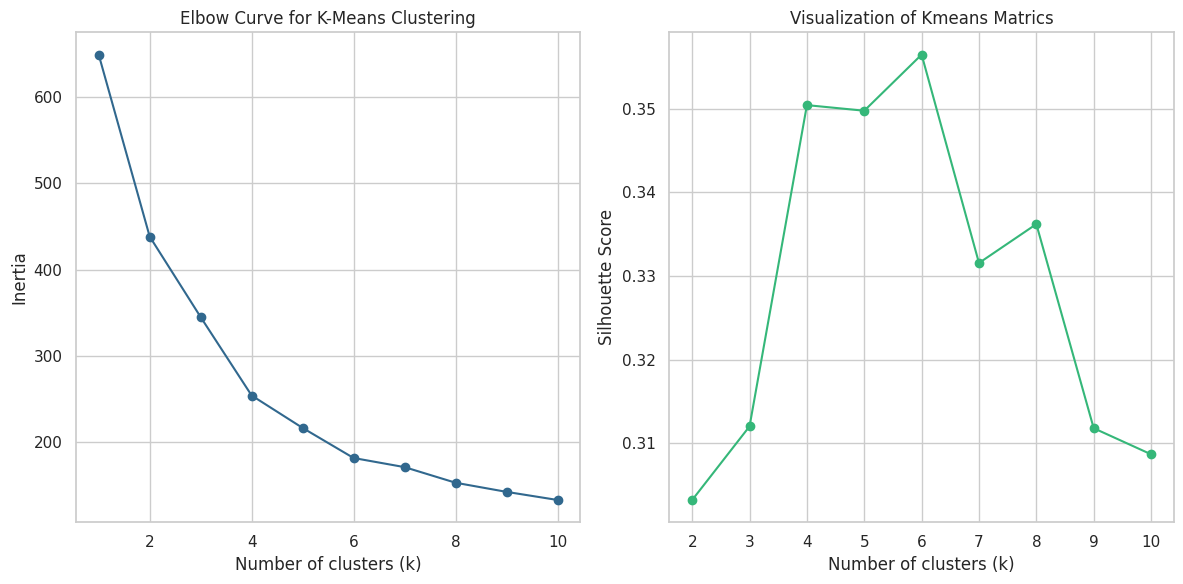

In [17]:
inertia = []
silhouette_scores = []

# Perform K-Means clustering for different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    inertia.append(kmeans.inertia_)

    if k > 1:
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(transformed_df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(None)

# colour
sns.set(style='whitegrid')
colors = sns.color_palette('viridis', n_colors=2)

# Plot the elbow curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), inertia, marker='o', color=colors[0])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-Means Clustering')
plt.grid(True)

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), silhouette_scores, marker='o', color=colors[1])
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means Clustering')
plt.grid(True)

plt.tight_layout()
plt.title('Visualization of Kmeans Matrics')
plt.savefig('Visualization of Kmeans Matrics')
plt.show()


## optimal k is found at 6

### Final K-Means Model: Training and Label Assignment

In this step, we use the **optimal number of clusters** (determined using the **Elbow Method**) to train the final K-Means model and assign the resulting **cluster labels** to the transformed dataset.


    1. Based on the **Elbow Method**, we determine that the optimal number of clusters is **6**. This means that the data is best grouped into 6 distinct clusters.
    2. Train the Final K-Means Model
    3. Add Cluster Labels to DataFrame:
    4. Preview the Resulting Data:


In [18]:
# best k by elbow method is
optimal_k = 6

# Train final K-Means model
kmeans_final = KMeans(n_clusters = optimal_k, random_state = 42)
final_labels = kmeans_final.fit_predict(transformed_df)

In [19]:
# Add the cluster labels to your DataFrame
transformed_df['Cluster'] = final_labels
transformed_df.sample(5)

Age  Annual Income (k$)  Spending Score (1-100)  Gender_encoded  \
20  -0.276302           -1.395474               -0.590088             1.0   
102  2.020232            0.054964                0.341630             1.0   
132 -0.993969            0.436658               -0.628909             0.0   
84  -1.281035           -0.250391                0.263987             0.0   
199 -0.635135            2.917671                1.273347             1.0   

     Cluster  
20         2  
102        0  
132        5  
84         5  
199        1

## Evaluate the Model

### Evaluating Cluster Centers and Analyzing Cluster Sizes

In this step, we evaluate the **cluster centers** and analyze the **cluster sizes** after performing K-Means clustering on the data. This helps to understand the central locations of the clusters and how many data points each cluster contains.

#### 1. **Cluster Centers**:
   - **Cluster centers** (or centroids) are the mean positions of the data points within each cluster.
   - These centers represent the "core" of each cluster in the feature space, where each cluster's points are closest to the centroid.

   We use the `cluster_centers_` attribute of the fitted KMeans model to obtain the centroids.



In [20]:
# Evaluate cluster centers
centers = kmeans_final.cluster_centers_
print("Cluster Centers:\n", centers)

# Analyze cluster sizes
cluster_sizes = pd.Series(final_labels).value_counts()
print("Cluster Sizes:\n", cluster_sizes)

Cluster Centers:
 [[ 1.25472096 -0.24021294 -0.04399777  0.42222222]
 [-0.44191719  0.99158305  1.23950275  0.46153846]
 [ 0.47895722 -1.30822992 -1.19644353  0.38095238]
 [ 0.17329545  1.06645385 -1.2980103   0.58823529]
 [-0.99396865 -1.34734766  1.06404834  0.43478261]
 [-0.85043527 -0.14894113 -0.04147777  0.34210526]]
Cluster Sizes:
 0    45
1    39
5    38
3    34
4    23
2    21
Name: count, dtype: int64


### Visualizing Clusters and Centroids: Scatter Plot
In this step, we visualize the **clusters** formed by the K-Means algorithm and the corresponding **centroids** on a scatter plot. This visualization helps in understanding the distribution of data points across the clusters and the positions of the cluster centers.

#### 1. **Scatter Plot of Clusters**:
   - We plot the transformed data with **Age** on the x-axis and **Annual Income (k$)** on the y-axis.
   - Each data point is colored based on the cluster it belongs to, using the **viridis** color palette.

#### 2. **Cluster Centroids**:
   - The centroids (cluster centers) are plotted as red **'X'** markers on the scatter plot. These represent the mean position of all the data points within each cluster.


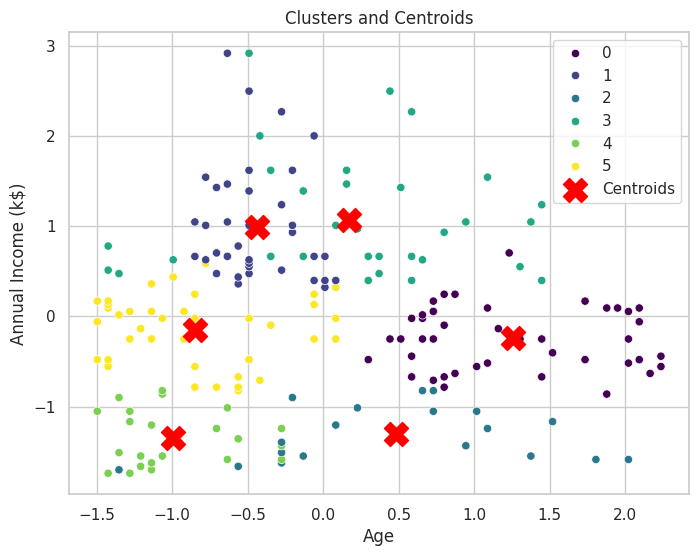

In [21]:
plt.figure(figsize=(8, 6))

# Scatter plot of clusters
sns.scatterplot(x=transformed_df.iloc[:, 0], y=transformed_df.iloc[:, 1], hue='Cluster', data=transformed_df, palette='viridis', legend='full')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('Clusters and Centroids')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)
plt.savefig('Clusters and Centroids')
plt.show()

## Insights from Clustering Analysis

1. **Cluster Formation**:
   - The data is grouped into six clusters, each represented by different colors.
   - Clusters are based on **Age** and **Annual Income (k$)**.

2. **Centroids (Red Crosses)**:
   - Represent the central point of each cluster.
   - Help in understanding the key characteristics of each group.

3. **Observations**:
   - Some clusters are more spread out, while others are denser.
   - The clustering suggests patterns in income distribution relative to age.

4. **Potential Use Cases**:
   - Customer segmentation for targeted marketing.
   - Identifying income-age group trends for business strategies.


### DIMENTIONALITY REDUCTION
### Visualizing Clusters Using PCA (Principal Component Analysis)

In this step, **Principal Component Analysis (PCA)** is used to reduce the dimensionality of the dataset from high-dimensional space to 2D. This reduction helps in visualizing how well the clusters are separated and how the data points are distributed.

#### 1. **Dimensionality Reduction**:
   - PCA is a technique that transforms the original features into a new set of axes, called **principal components**, which capture the most variance in the data. In this case, we reduce the dataset to **two principal components (PC1 and PC2)**, making it easier to plot the data in a two-dimensional space.
   - The transformation is applied to the features of the dataset excluding the cluster labels, ensuring that we only focus on the data for visualization.

#### 2. **Creating a Plotting DataFrame**:
   - After performing PCA, the transformed data is stored in a new DataFrame, which includes the two principal components (`PC1` and `PC2`).
   - Additionally, the cluster labels assigned earlier are added to this DataFrame. This allows us to color-code the data points based on the cluster they belong to.

#### 3. **Cluster Visualization**:
   - A **scatter plot** is created using the two principal components (`PC1` and `PC2`) on the x- and y-axes, respectively.
   - The data points are colored according to their assigned cluster labels, which helps visualize the separation between the clusters in the reduced 2D space.
   - This visualization shows how the data points from different clusters are distributed, helping assess how well the clustering algorithm has grouped similar data points together.

#### Key Insights:
- **Cluster Separation**: The scatter plot reveals how distinct or overlapping the clusters are in 2D space. Well-separated clusters indicate effective clustering, while overlapping clusters may require further analysis or adjustment.
- **PCA for Visualization**: By reducing the dimensions of the data, PCA simplifies the complexity of the dataset and aids in interpreting the clustering results, all while retaining the key variance from the original dataset.


In [22]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(transformed_df.drop('Cluster', axis=1))


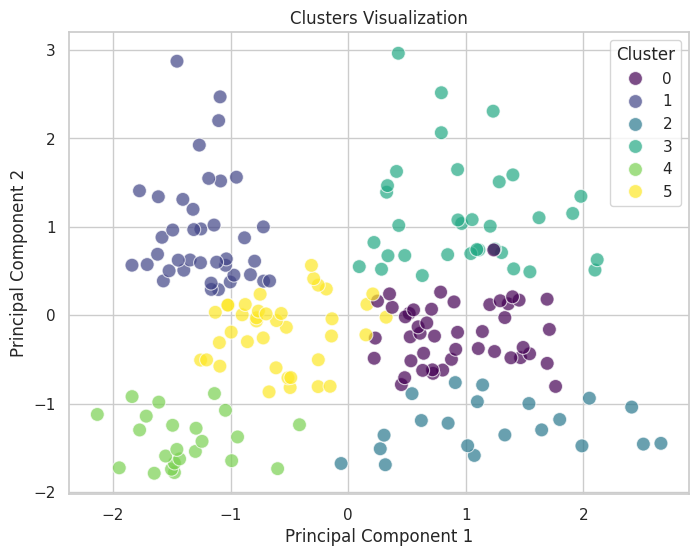

In [23]:
# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = final_labels

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


## PCA-Based Clustering Analysis

1. **Dimensionality Reduction**:
   - Principal Component Analysis (PCA) is used to project data into two components.
   - Helps in visualizing high-dimensional data in a 2D space.

2. **Cluster Separation**:
   - Six distinct clusters are identified, each with different color labels.
   - Clusters exhibit clear separation, indicating meaningful groupings.

3. **Observations**:
   - Some clusters are well-separated, while others slightly overlap.
   - The spread suggests variance in feature contributions to clustering.

4. **Application**:
   - Useful for customer segmentation.
   - Enhances data interpretability while preserving important patterns.


## SAVE MODEL

In [24]:
import pickle

# Save the trained model to a file
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

----

### üåü **Crafted especially for beginners to make things easier** üåü  
### üöÄ Dive into VTE (Virtual Training Environment) and start learning today! üìö‚ú®  
### Feel free to **upvote** üëç and **share** üîÑ with others. Let's grow together! ü§ùüí°
